### This notebook displays how to crawl all the page links from a webpage and childpages upto maximum specified depth of pages.



For example, there will be a starting page. In this project, I am using the start url https://www.canada.ca/en/immigration-refugees-citizenship/. So I am going to extract all the weblinks on this page, and subsequently the links within the extracted weblinks pages, upto the max depth of 2


```
-start_url_link (A)
    -url_link_1 (B)
        --url_link_1_node_1 (E)
            --url_link_1_node_1_node1(C)
        --url_link_1_node_2 (F)     
    -url_link_2 (C)   
        --url_link_2_node_3 (G)   
    -url_link_3 (D)
        --url_link_3_node_1 (C)
        --url_link_3_node_2 (G)
        --url_link_3_node_2 (H)
```


Notice how this is not a tree, but a directed graph, as one page might refer back to another page up in the hierarchy.

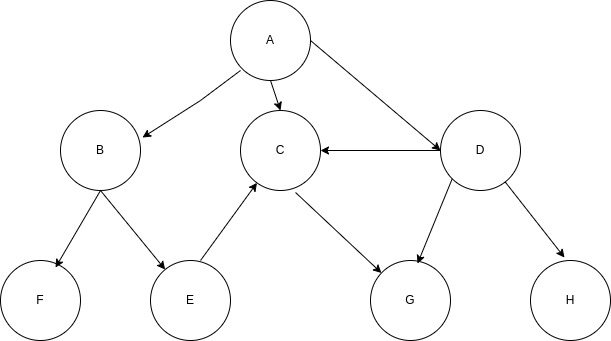



In [5]:
# Imports 

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, urlunparse
from enum import Enum
import re
from collections import deque


In [ ]:


# Start URL
start_url = "https://www.canada.ca/en/immigration-refugees-citizenship/services/immigrate-canada/"

# Domain filter
base_domain = urlparse(start_url).netloc

# Track visited URLs to avoid loops
visited = set()

# immigration related path
immigration_path_path = "/en/immigration-refugees-citizenship/"

MAX_DEPTH = 3  # set your desired max depth

def is_subpage(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc == base_domain and parsed_url.path.startswith(immigration_path_path)


class Language(Enum):
    ENGLISH = 'English'
    FRENCH = 'French'
    UNKNOWN = 'Unknown'


def get_language_from_url(url):
    """
    Determines the language of a Canada.ca URL based on the path.
    Returns 'English', 'French', or 'Unknown'.
    """
    path = urlparse(url).path.lower()

    if '/en/' in path:
        return Language.ENGLISH
    elif '/fr/' in path:
        return Language.FRENCH
    else:
        return Language.UNKNOWN
    
    
def clean_url(full_url:str):
    """
    This method cleans up a URL string
    i) removes the fragment identifier or hash anchor #wb-cont
    ii ) removes suffix .html from url
    
    The cleaning of url prevents scraping of duplicate urls of different forms.
    
    Args:
        full_url (str): raw url string 

    Returns:
        _type_: clean url string
    """
    
    #  urlparse() breaks the URL into parts: scheme, netloc, path, params, query, and fragment.
    parsed = urlparse(full_url)

    #_replace() sets query and fragment to empty strings.
    clean = parsed._replace(query='', fragment='')
    
    # urlunparse() stitches the clean parts back together
    clean = urlunparse(clean)
    
    # Remove the '.html' extension if it exists
    clean = re.sub(r'\.html$', '', clean)
    return clean


def scrape_site(url, base_url):
    
    url = clean_url(url)
    
    # If already visited return
    if url in visited:
        return

    # Only scrape English pages
    language = get_language_from_url(url)
    if not language == Language.ENGLISH:
        return
    
    # Add url to visited 
    visited.add(url)

    try:
        response = requests.get(url, timeout=5)
        soup = BeautifulSoup(response.text, 'html.parser')
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return

    # Find all internal links (subpages)
    for link_tag in soup.find_all('a', href=True):
        href = link_tag['href']
        full_url = urljoin(url, href)
        
        # Only follow links within the same domain
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            scrape_site(full_url, base_url)


def scrape_page_links(url):
    """
    
    Returns all pages in the url to crawl

    Args:
        url (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    try:
        #print(f"Scraping: {url}")
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Extract and return links to subpages
        links = set()
        for link_tag in soup.find_all("a", href=True):
            full_url = urljoin(url, link_tag["href"])
            
            full_url = clean_url(full_url)

            # Only scrape English language pages
            language = get_language_from_url(full_url)
            
            if is_subpage(full_url) and full_url not in visited and language == Language.ENGLISH:
                links.add(full_url)
        return links
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return set()


In [ ]:
def crawl(start_url):
    to_visit = set([start_url])
    
    queue = deque([(start_url, 0)])  # each item is (url, depth)
    
    #bfs crawling
    while queue:
        current_url, depth = queue.popleft()
        
        
        if current_url in visited or depth > MAX_DEPTH:
            continue
        
        visited.add(current_url)
        print(f"[Depth {depth}] Scraping: {current_url}")
        
        out_links = scrape_page_links(current_url)
        for link in out_links:
            if link not in visited:
                queue.append((link, depth + 1))
                
        print ("new_links added", out_links)

crawl(start_url)


In [ ]:
visited

In [ ]:
# Save set as plain text (one item per line)
with open('../data/crawled_page_links.txt', 'w') as f:
    for item in visited:
        f.write(f"{item}\n")
